In [1]:
# AWS SageMaker python SDK
import sagemaker
import tensorflow as tf

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from sagemaker import get_execution_role
import sagemaker_pyspark


# tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# pyspark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType, StringType

# Additionl libraries
import numpy as np
import random
import os
from PIL import Image
import numpy as np
# import matplotlib.pyplot as plt
# import tarfile
import urllib
import boto3



In [5]:
print('sagemaker version', sagemaker.__version__)
print('tensorflow version', tf.__version__)
print('numpy version', np.__version__)
print('boto3 version',boto3.__version__)

sagemaker version 2.59.3
tensorflow version 1.15.5
numpy version 1.18.1
boto3 version 1.18.45


Tout d’abord, nous importons les modules nécessaires et créons la SparkSession avec les dépendances SageMaker-Spark attachées

In [ ]:
# Vérifions la connection au bucket

In [6]:
def verif_connect_to_from_bucket(bucket_name):
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucket_name)
    for image in my_bucket.objects.limit(3):
        print(image.key)

In [10]:
bucket_name = 'ocfruits17102021'
verif_connect_to_from_bucket(bucket_name)

Fruits/Apple_Braeburn/0_100.jpg
Fruits/Apple_Braeburn/100_100.jpg
Fruits/Apple_Braeburn/101_100.jpg


In [8]:
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

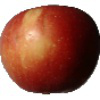

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
import io

def read_image_from_s3(bucket, key, region_name='eu-west-1-1'):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    s3 = boto3.resource('s3', region_name='ap-southeast-1')
    bucket = s3.Bucket(bucket)
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return im

read_image_from_s3(bucket_name, 'Fruits/Apple_Braeburn/0_100.jpg')   

In [40]:
# chargement du model

model = VGG16(weights='imagenet', include_top=False) # La suppression des dernières couches se fait en ajoutant l'argument  include_top = False  lors de l'import du modèle pré-entraîné.
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [47]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Fruits')\
        .getOrCreate()

sc = spark.sparkContext



In [45]:
path = "Fruits"
images = spark.read.format("image") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(path)

display(images.limit(5))